# What is happening with death rates

In [652]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import seaborn as sns
%matplotlib inline

!pwd

/home/barry/projects/covid_projects/fatality_analysis


# Load OWID Base Dataset 

In [653]:
df = pd.read_pickle('../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max()

((39316, 10), 208, Timestamp('2020-08-28 00:00:00'))

# Focus on the EU
EU countries seem to have a good record in providing testing data so it's a good placve to start.

## EU Countries with Tests

In [654]:
in_eu = df['region'] == 'eu'

df[in_eu].shape, df[in_eu]['country'].nunique()

((5969, 10), 27)

In [655]:
df.groupby('country').apply(lambda g: g['new_tests'].notnull().mean()>.25).mean()

0.39903846153846156

In [656]:
min_test_frac = 0.5  # Min fraction days with tests

countries_with_tests = df.groupby('country').apply(lambda g: g['new_tests'].notnull().mean()>min_test_frac).index

with_tests = df['country'].isin(countries_with_tests)

df[with_tests].shape, df[with_tests]['country'].nunique(), df[in_eu & with_tests]['country'].nunique()

((39316, 10), 208, 27)

In [657]:
eu = df[in_eu & with_tests].copy()
eu.shape, eu.country.nunique()

((5969, 10), 27)

In [658]:
eu.groupby('country').apply(
    lambda g: g.set_index('date')['new_cases'].rolling('7d').apply(lambda v: v[0])
).tail()

country  date      
Sweden   2020-08-24     63.0
         2020-08-25    174.0
         2020-08-26    314.0
         2020-08-27    351.0
         2020-08-28    333.0
Name: new_cases, dtype: float64

In [659]:
eu[eu['country']=='Sweden'].set_index('date')['new_cases'].tail(10)

date
2020-08-19    174.0
2020-08-20    314.0
2020-08-21    351.0
2020-08-22    333.0
2020-08-23    298.0
2020-08-24    160.0
2020-08-25     57.0
2020-08-26    182.0
2020-08-27    227.0
2020-08-28    171.0
Name: new_cases, dtype: float64

## Per 100k Metrics

In [660]:
new_cols = eu.filter(like='new_').columns

for new_col in new_cols: eu[new_col+'_per_100k'] = 100000*eu[new_col]/eu['population']
    
eu.tail()

,date,country,country_code,country_id,continent,region,new_cases,new_deaths,new_tests,population,new_cases_per_100k,new_deaths_per_100k,new_tests_per_100k
34731,2020-08-24,Sweden,SWE,SE,Europe,eu,160.0,1.0,NaN,10099270.0,1.584273,0.009902,NaN
34732,2020-08-25,Sweden,SWE,SE,Europe,eu,57.0,0.0,NaN,10099270.0,0.564397,0.000000,NaN
34733,2020-08-26,Sweden,SWE,SE,Europe,eu,182.0,0.0,NaN,10099270.0,1.802110,0.000000,NaN
34734,2020-08-27,Sweden,SWE,SE,Europe,eu,227.0,0.0,NaN,10099270.0,2.247687,0.000000,NaN
34735,2020-08-28,Sweden,SWE,SE,Europe,eu,171.0,0.0,NaN,10099270.0,1.693192,0.000000,NaN


## Prevalence/Current Cases

In [661]:
eu = eu.set_index(['country', 'date']).join(
    eu.groupby('country').apply(lambda g: g.set_index('date')[['new_cases_per_100k']].rolling('14d').sum()).rename(
        columns={'new_cases_per_100k':'curr_cases_per_100k'})).reset_index()

eu.shape

(5969, 14)

## 7d Rolling Means

In [662]:
per_100k_cols = eu.filter(like='_per_100k').columns

for per_100k_col in per_100k_cols:
    rolling_col = 'rolling_'+per_100k_col
    eu = eu.set_index(['country', 'date']).join(eu.groupby('country').apply(lambda g: g.set_index('date')[[per_100k_col]].rolling('7d').mean()).rename(
        columns={per_100k_col:rolling_col})).reset_index()

eu.shape

(5969, 18)

## A Simple Estimate of R

In [663]:
lag = 7

est_r = pd.DataFrame(
    eu.groupby('country').apply(lambda g: g.set_index('date')['rolling_new_cases_per_100k']/g.set_index('date')['rolling_curr_cases_per_100k'].shift(lag)),
    columns=['est_r']
)

eu = eu.set_index(['country', 'date']).join(est_r).reset_index()
eu.shape

(5969, 19)

date
2020-08-24    0.123205
2020-08-25    0.122904
2020-08-26    0.116818
2020-08-27    0.113464
2020-08-28    0.108856
Name: est_r, dtype: float64

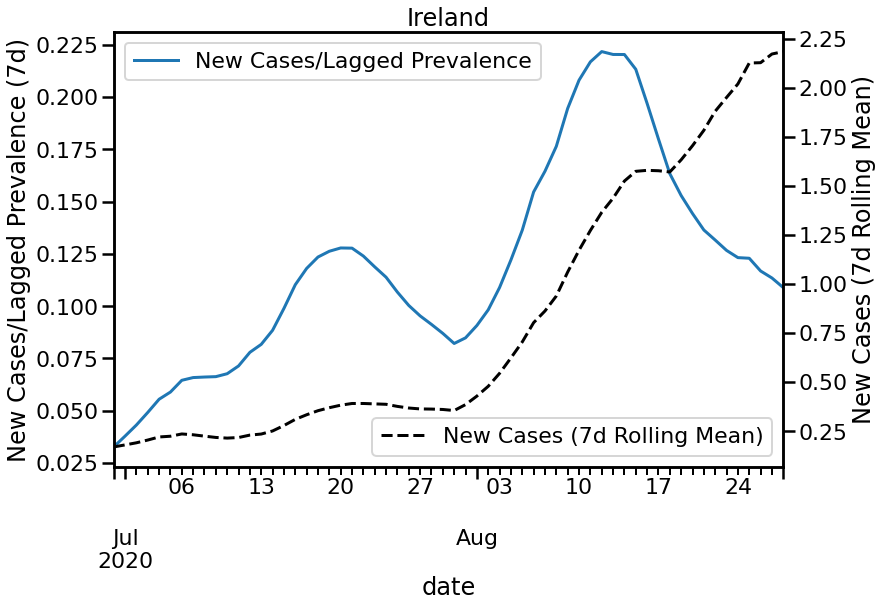

In [665]:
sns.set_context('poster')

fig, ax = plt.subplots(figsize=(12, 8))

country = 'Ireland'
eu[eu['country']==country].set_index('date')['est_r'].rolling('7d').mean().iloc[-60:].plot(ax=ax, label='New Cases/Lagged Prevalence')

ax.set_ylabel('New Cases/Lagged Prevalence (7d)')

bx = ax.twinx()

eu[eu['country']==country].set_index('date')['rolling_new_cases_per_100k'].rolling('7d').mean().iloc[-60:].plot(ax=bx, c='k', ls='--', label='New Cases (7d Rolling Mean)')

bx.set_ylabel('New Cases (7d Rolling Mean)')

ax.legend(loc='upper left')
bx.legend(loc='lower right')

ax.set_title(country)

eu[eu['country']==country].set_index('date')['est_r'].rolling('7d').mean().tail()

In [666]:
eu[eu['country']==country].set_index('date').tail()

,country,country_code,country_id,continent,region,new_cases,new_deaths,new_tests,population,new_cases_per_100k,new_deaths_per_100k,new_tests_per_100k,curr_cases_per_100k,rolling_new_cases_per_100k,rolling_new_deaths_per_100k,rolling_new_tests_per_100k,rolling_curr_cases_per_100k,est_r
date,,,,,,,,,,,,,,,,,,
2020-08-24,Ireland,IRL,IE,Europe,eu,61.0,0.0,4838.0,4937796.0,1.235369,0.0,97.978936,25.456702,2.059913,0.008679,150.619542,25.184747,0.107019
2020-08-25,Ireland,IRL,IE,Europe,eu,147.0,0.0,4998.0,4937796.0,2.977037,0.0,101.219248,27.299629,2.323188,0.008679,152.526118,25.887779,0.116681
2020-08-26,Ireland,IRL,IE,Europe,eu,85.0,0.0,NaN,4937796.0,1.721416,0.0,NaN,28.352731,2.030981,0.005786,160.422450,26.333322,0.096748
2020-08-27,Ireland,IRL,IE,Europe,eu,162.0,0.0,NaN,4937796.0,3.280816,0.0,NaN,30.884224,2.360799,0.005786,142.217297,27.146293,0.107312
2020-08-28,Ireland,IRL,IE,Europe,eu,90.0,0.0,NaN,4937796.0,1.822676,0.0,NaN,30.863973,2.247967,0.002893,111.547743,27.782783,0.097052


In [634]:
ireland = eu[eu['country']=='Ireland'].set_index('date')
ireland.loc[datetime(2020, 3, 1):][['rolling_new_cases_per_100k', 'rolling_curr_cases_per_100k', 'est_r']].head(20)

,rolling_new_cases_per_100k,rolling_curr_cases_per_100k,est_r
date,,,
2020-03-01,0.002893,0.002893,inf
2020-03-02,0.002893,0.005786,inf
2020-03-03,0.003375,0.008679,inf
2020-03-04,0.006751,0.014466,inf
2020-03-05,0.020252,0.031824,inf
2020-03-06,0.043879,0.069435,inf
2020-03-07,0.060756,0.121512,inf
2020-03-08,0.060756,0.170695,21.000000
2020-03-09,0.067507,0.225665,11.666667


In [635]:
min_df = pd.read_csv('../fatality_analysis/ireland_r_numbers.csv', names=['country', 'date', 'r'], header=None, parse_dates=[1]).set_index('date')['r']

In [636]:
ireland = ireland.join(min_df)

In [637]:
ireland[['est_r', 'r']].dropna().corr()

,est_r,r
est_r,1.000000,0.746565
r,0.746565,1.000000


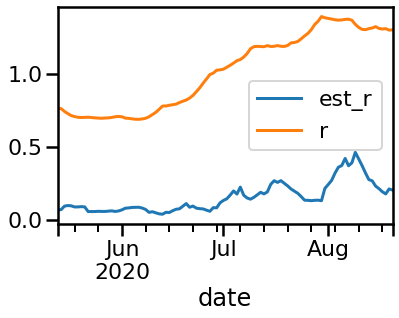

In [638]:
ireland[['est_r', 'r']].dropna().iloc[-100:].plot()

## The First Wave
Focus on EU countries with a well defined first wave.

In [618]:
first_wave_countries = [
    'Austria', 'Belgium', 'Croatia', 'Cyprus',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
    'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
    'Slovakia', 'Slovenia', 'Spain'
]

first_wave = eu['country'].isin(first_wave_countries)

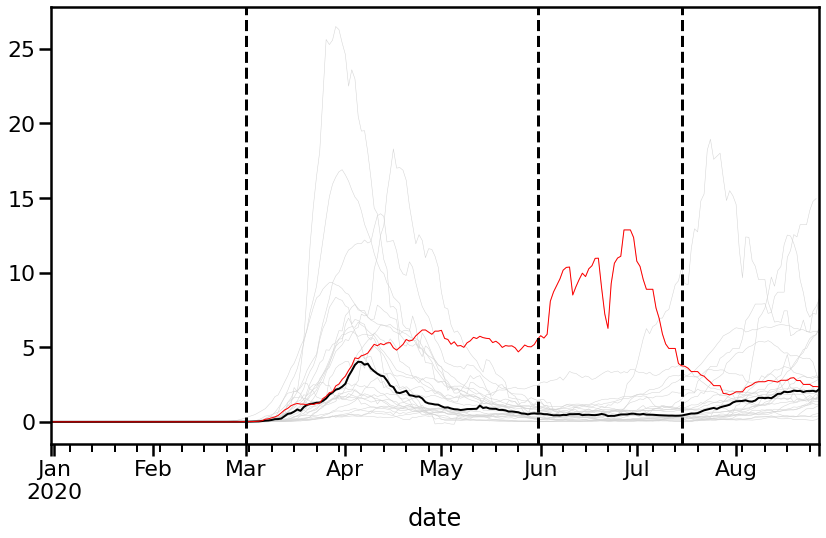

In [619]:
sns.set_context('poster')

fig, ax = plt.subplots(figsize=(12, 8))

eu.groupby('country').apply(lambda g: g.set_index('date')['rolling_new_cases_per_100k'].plot(ax=ax, c='lightgrey', lw=.5))

eu.groupby('date')['rolling_new_cases_per_100k'].median().plot(ax=ax, c='k', lw=2)

eu[eu['country']=='Sweden'].groupby('date')['rolling_new_cases_per_100k'].median().plot(ax=ax, c='r', lw=1)




ax.legend().remove()

wave_1_start, wave_1_end = datetime(2020, 3, 1), datetime(2020, 5, 31)
wave_2_start = datetime(2020, 7, 15)

ax.axvline(wave_1_start, c='k', ls='--')
ax.axvline(wave_1_end, c='k', ls='--')
ax.axvline(wave_2_start, c='k', ls='--')



fig.tight_layout()

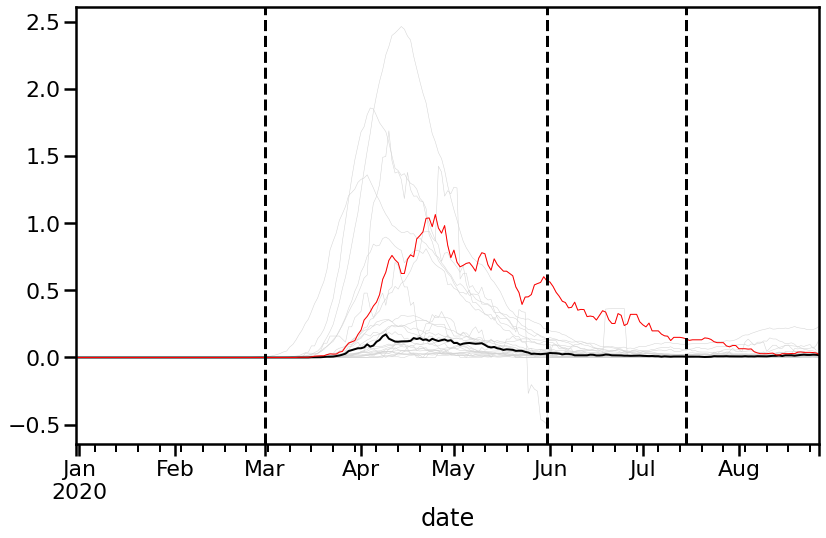

In [620]:
sns.set_context('poster')

fig, ax = plt.subplots(figsize=(12, 8))

eu.groupby('country').apply(lambda g: g.set_index('date')['rolling_new_deaths_per_100k'].plot(ax=ax, c='lightgrey', lw=.5))

eu.groupby('date')['rolling_new_deaths_per_100k'].median().plot(ax=ax, c='k', lw=2)

eu[eu['country']=='Sweden'].groupby('date')['rolling_new_deaths_per_100k'].median().plot(ax=ax, c='r', lw=1)




ax.legend().remove()

wave_1_start, wave_1_end = datetime(2020, 3, 1), datetime(2020, 5, 31)
wave_2_start = datetime(2020, 7, 15)

ax.axvline(wave_1_start, c='k', ls='--')
ax.axvline(wave_1_end, c='k', ls='--')
ax.axvline(wave_2_start, c='k', ls='--')



fig.tight_layout()

In [326]:
eu[eu['country']=='Sweden'].set_index('date')['new_tests'].notnull().mean()

0.23236514522821577

Austria
Belgium
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France


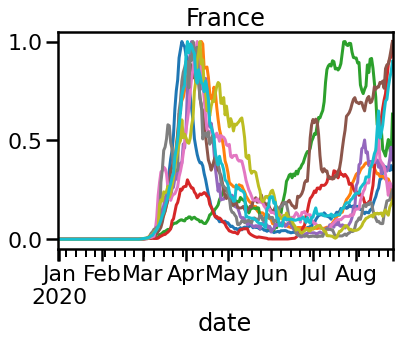

In [112]:
for country in eu['country'].unique()[:10]:
    
    print(country)
    rel_new_cases_per_day_for_countries.loc[country].plot(title=country)

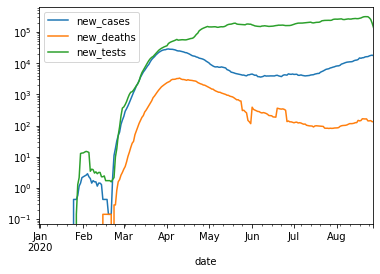

In [54]:
eu.groupby('date')[['new_cases', 'new_deaths', 'new_tests']].sum().rolling('7d').mean().plot()
plt.yscale('log')

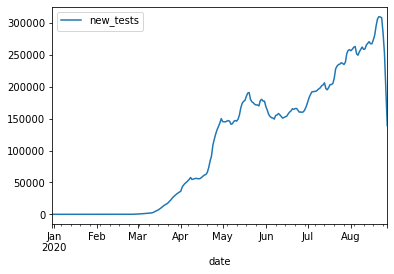

In [52]:
eu.groupby('date')[['new_tests']].sum().rolling('7d').mean().plot()

# Cases & Deaths

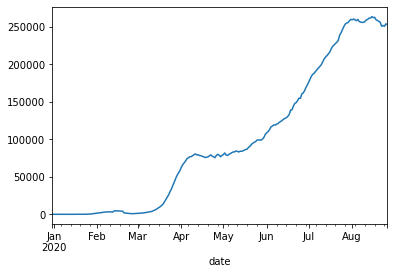

In [5]:
df.groupby('date')['new_cases'].sum().rolling('7d').mean().plot()

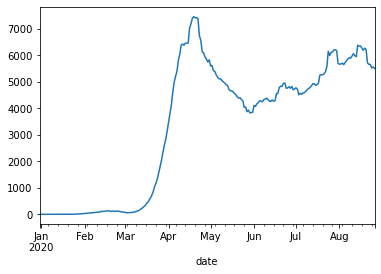

In [6]:
df.groupby('date')['new_deaths'].sum().rolling('7d').mean().plot()

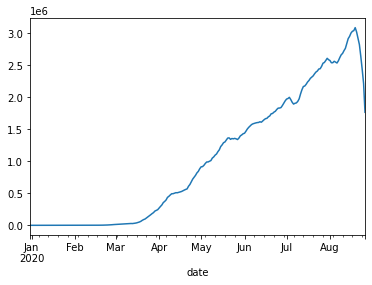

In [7]:
df.groupby('date')['new_tests'].sum().rolling('7d').mean().plot()